In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
import shap
import pickle

In [2]:
# Step 1: Kaggle Dataset Download
!pip install --upgrade kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"your_username","key":"your_kaggle_api_key"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ananthu017/emotion-detection-fer --force

# Step 2: Extract Dataset
import zipfile
with zipfile.ZipFile('./emotion-detection-fer.zip', 'r') as zip_ref:
    zip_ref.extractall('./emotion_data')

Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
  0% 0.00/65.2M [00:00<?, ?B/s]
100% 65.2M/65.2M [00:00<00:00, 986MB/s]


In [3]:
# Step 3: Load and Preprocess Images
def load_images(base_dir):
    images, labels = [], []
    for category in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category)
        if os.path.isdir(category_path):
            for file in os.listdir(category_path):
                if file.endswith('.jpg') or file.endswith('.png'):
                    img = cv2.imread(os.path.join(category_path, file), cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (48, 48))
                    images.append(img)
                    labels.append(category)
    return np.array(images), np.array(labels)

train_dir = "./emotion_data/train"
test_dir = "./emotion_data/test"
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

# Normalize Images
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Encode Labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [4]:
# Step 4: Build and Train CNN Model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.fit(X_train, y_train, epochs=30, validation_split=0.2)
cnn_acc = model_cnn.evaluate(X_test, y_test)[1]
print(f'CNN Accuracy: {cnn_acc * 100:.2f}%')
model_cnn.save("cnn_emotion_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.3366 - loss: 1.5381 - val_accuracy: 0.0369 - val_loss: 8.0169
Epoch 2/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4900 - loss: 1.2476 - val_accuracy: 0.0435 - val_loss: 9.0286
Epoch 3/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5373 - loss: 1.1421 - val_accuracy: 0.0542 - val_loss: 10.4817
Epoch 4/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5594 - loss: 1.0874 - val_accuracy: 0.0489 - val_loss: 10.9395
Epoch 5/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5912 - loss: 1.0165 - val_accuracy: 0.0496 - val_loss: 11.6685
Epoch 6/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6146 - loss: 0.9745 - val_accuracy: 0.0453 - val_loss: 15.2839
Epoch 7/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6291 - loss: 0.9302 - val_accuracy: 0.0563 - val_loss: 13.5093
Epoch 8/30
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6496 - loss: 0.8905 - val_accur

CNN Accuracy: 50.72%


In [5]:

# Step 5: Train Machine Learning Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# SVM
model_svm = SVC(kernel='linear')
model_svm.fit(X_train_flat, y_train)
svm_acc = accuracy_score(y_test, model_svm.predict(X_test_flat))
pickle.dump(model_svm, open("svm_emotion_model.pkl", "wb"))

# Random Forest
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train_flat, y_train)
rf_acc = accuracy_score(y_test, model_rf.predict(X_test_flat))
pickle.dump(model_rf, open("rf_emotion_model.pkl", "wb"))

# Logistic Regression
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_flat, y_train)
lr_acc = accuracy_score(y_test, model_lr.predict(X_test_flat))
pickle.dump(model_lr, open("lr_emotion_model.pkl", "wb"))

# KNN
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train_flat, y_train)
knn_acc = accuracy_score(y_test, model_knn.predict(X_test_flat))
pickle.dump(model_knn, open("knn_emotion_model.pkl", "wb"))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


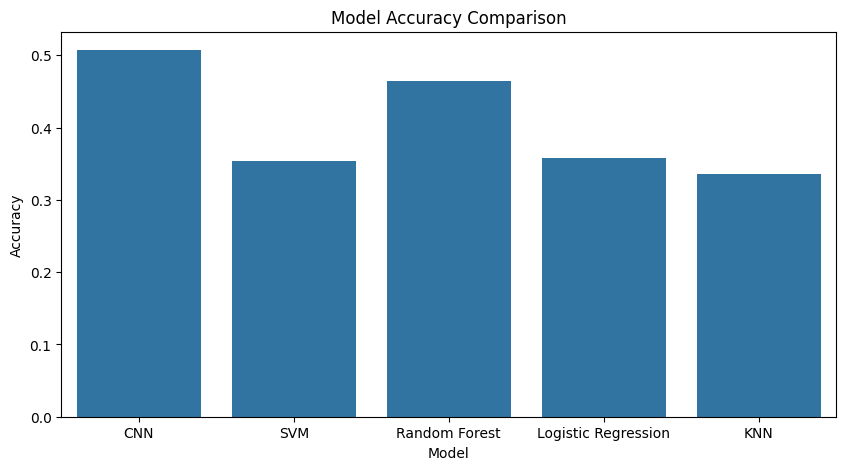

In [6]:
# Step 6: Accuracy Comparison Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=["CNN", "SVM", "Random Forest", "Logistic Regression", "KNN"],
            y=[cnn_acc, svm_acc, rf_acc, lr_acc, knn_acc])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step


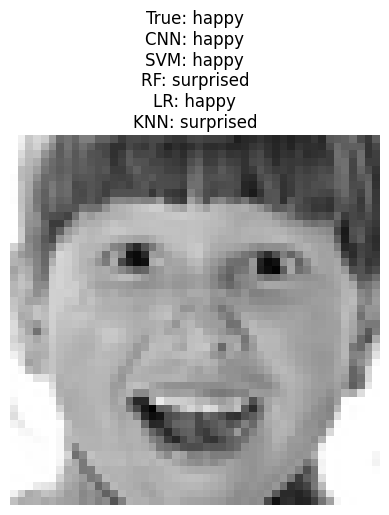

In [8]:
# Random Image Prediction
import random # Import the random module

def predict_random_image():
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx].reshape(48, 48)
    true_label = le.inverse_transform([y_test[idx]])[0]
    img_flat = X_test_flat[idx].reshape(1, -1)

    cnn_pred = le.inverse_transform([np.argmax(model_cnn.predict(X_test[idx].reshape(1, 48, 48, 1)))])[0]
    svm_pred = le.inverse_transform([model_svm.predict(img_flat)[0]])[0]
    rf_pred = le.inverse_transform([model_rf.predict(img_flat)[0]])[0]
    lr_pred = le.inverse_transform([model_lr.predict(img_flat)[0]])[0]
    knn_pred = le.inverse_transform([model_knn.predict(img_flat)[0]])[0]

    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nCNN: {cnn_pred}\nSVM: {svm_pred}\nRF: {rf_pred}\nLR: {lr_pred}\nKNN: {knn_pred}")
    plt.axis('off')
    plt.show()

predict_random_image()

In [9]:
from google.colab import files

# Download CNN Model
files.download("cnn_emotion_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>